<a href="https://colab.research.google.com/github/PhiDung-hub/CZ4003/blob/main/Spatial_Pyramid_Matching_CZ4003_Optional_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spatial Pyramid Matching
---
This note book implement SPM method from [Lazebnik et al. 2006](http://www.di.ens.fr/willow/pdfs/cvpr06b.pdf). For an excellent survey of pre-deep-learning feature encoding methods for bag of words models, see [Chatfield et al, 2011](http://www.robots.ox.ac.uk/~vgg/research/encoding_eval/).

## Implementation specs
--- 
Procedure are replicated as in the original paper. Hyper-parameter are:      
- L=0,2   ||    M=200
- SIFT descriptor and K-means clustering for feature extractions

## Dataset
---
[Caltech101](http://www.vision.caltech.edu/Image_Datasets/Caltech101/): Pictures of objects belonging to 101 categories. About 40 to 800 images per category. Most categories have about 50 images. Collected in September 2003 by Fei-Fei Li, Marco Andreetto, and Marc 'Aurelio Ranzato.  The size of each image is roughly 300 x 200 pixels.


## Data Loading 
Load Caltech101 data and split them into train/test set according to the original paper specification: 

- train on 30 image per class and test on the rest 
- limit number of test image to 50
- All data are loaded grayscale

In [ ]:
# import packages here
import sys
# !{sys.executable} -m pip install opencv-python
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import pandas as pd
import glob

In [ ]:
# # Run this cell to connect to your Drive folder

# from google.colab import drive
# drive.mount('/content/gdrive')

In [ ]:
DATA_DIR = "Dropbox/data/101_ObjectCategories"
x = len('Dropbox/data/101_ObjectCategories\\') # dummy string in class name.
class_names = [name[x:] for name in glob.glob(f'{DATA_DIR}/*')]
class_names = dict(zip(range(0,len(class_names)), class_names))
print(f'0: {class_names[0]}; 5: {class_names[5]}; 10: {class_names[10]}')
print(f'Number of class: {len(class_names)}')

0: accordion; 5: barrel; 10: brain
Number of class: 102


In [ ]:
def load_dataset(path, train_size=30, max_test_size=50):
    train_data = []
    train_labels = []
    test_data = []
    test_labels = []
    for id, class_name in class_names.items():
        img_path_class = glob.glob(path + class_name + '/*.jpg')
        # get train_data
        train_path_class = img_path_class[:train_size]
        train_labels.extend([id]*len(train_path_class))
        for filename in train_path_class:
            train_data.append(cv2.imread(filename, cv2.IMREAD_GRAYSCALE))
        
        if train_size + max_test_size > len(img_path_class): 
            test_path_class = img_path_class[train_size:]
        else:
            test_path_class = img_path_class[train_size:train_size+max_test_size]
        test_labels.extend([id]*len(test_path_class))
        for filename in test_path_class:
            test_data.append(cv2.imread(filename, cv2.IMREAD_GRAYSCALE))

    return train_data, train_labels, test_data, test_labels

# load the dataset
train_data, train_labels, test_data, test_labels = load_dataset(f'{DATA_DIR}/')
train_num = len(train_labels); test_num = len(test_labels)
print(f'Number of image \t train: {train_num} \t test: {test_num}')

Number of image 	 train: 3060 	 test: 2995


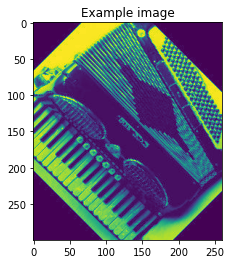

In [ ]:
plt.imshow(train_data[0]);
plt.title("Example image"); 

In [ ]:
# DUMMY IMPLEMENTATION OF features extraction

def extract_feat(raw_data):
    feat_dim = 200
    feat = np.zeros((len(raw_data), feat_dim), dtype=np.float32)
    for i in range(0,feat.shape[0]):
        feat[i] = np.reshape(raw_data[i], (raw_data[i].size))[:feat_dim] # dummy implemtation
    return feat

feat = extract_feat(train_data)

# model training: take feature and label, return model
def train(X, Y):
    return 0 # dummy implementation

# prediction: take feature and model, return label
def predict(model, x):
    return np.random.randint(len(class_names)) # dummy implementation

# evaluation
predictions = [-1]*len(feat)
for i in range(0, train_num):
    predictions[i] = predict(None, feat[i])
    
accuracy = sum(np.array(predictions) == train_labels) / float(train_num)

print ("The accuracy of dummy model is {:.2f}%".format(accuracy*100))

The accuracy of dummy model is 0.72%


## Problem 2: Bag of SIFT Representation + Nearest Neighbor Classifer
{40 points} After you have implemented a baseline scene recognition pipeline it is time to move on to a more sophisticated image representation — bags of quantized SIFT features. Before we can represent our training and testing images as bag of feature histograms, we first need to establish a vocabulary of visual words. We will form this vocabulary by sampling many local features from our training set (10's or 100's of thousands) and then cluster them with k-means. The number of k-means clusters is the size of our vocabulary and the size of our features. For example, you might start by clustering many SIFT descriptors into k=50 clusters. This partitions the continuous, 128 dimensional SIFT feature space into 50 regions. For any new SIFT feature we observe, we can figure out which region it belongs to as long as we save the centroids of our original clusters. Those centroids are our visual word vocabulary. Because it can be slow to sample and cluster many local features, the starter code saves the cluster centroids and avoids recomputing them on future runs.

Now we are ready to represent our training and testing images as histograms of visual words. For each image we will densely sample many SIFT descriptors. Instead of storing hundreds of SIFT descriptors, we simply count how many SIFT descriptors fall into each cluster in our visual word vocabulary. This is done by finding the nearest neighbor k-means centroid for every SIFT feature. Thus, if we have a vocabulary of 50 visual words, and we detect 220 distinct SIFT features in an image, our bag of SIFT representation will be a histogram of 50 dimensions where each bin counts how many times a SIFT descriptor was assigned to that cluster. The total of all the bin-counts is 220. The histogram should be normalized so that image size does not dramatically change the bag of features magnitude.

**Note**: 
- Instead of using SIFT to detect invariant keypoints which is time-consuming, you are recommended to densely sample keypoints in a grid with certain step size (sampling density) and scale.
- There are many design decisions and free parameters for the bag of SIFT representation (number of clusters, sampling density, sampling scales, SIFT parameters, etc.) so accuracy might vary from 50% to 60%.

**Hints**:
- Use [KMeans in Sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) to do clustering and find the nearest cluster centroid for each SIFT feature;
- Use `cv2.xfeatures2d.SIFT_create()` to create a SIFT object;
- Use `sift.compute()` to compute SIFT descriptors given densely sampled keypoints ([cv2.Keypoint](https://docs.opencv.org/3.0-beta/modules/core/doc/basic_structures.html?highlight=keypoint#keypoint)).

In [ ]:
from sklearn.cluster import KMeans
from sklearn import preprocessing

In [ ]:
# compute dense SIFT 
def computeSIFT(data):
    x = []
    for i in range(0, len(data)):
        sift = cv2.xfeatures2d.SIFT_create()
        img = data[i]
        step_size = 15
        kp = [cv2.KeyPoint(x, y, step_size) for x in range(0, img.shape[0], step_size) for y in range(0, img.shape[1], step_size)]
        dense_feat = sift.compute(img, kp)
        x.append(dense_feat[1])
        
    return x

# extract dense sift features from training images
x_train = computeSIFT(train_data)
x_test = computeSIFT(test_data)

all_train_desc = []
for i in range(len(x_train)):
    for j in range(x_train[i].shape[0]):
        all_train_desc.append(x_train[i][j,:])

all_train_desc = np.array(all_train_desc)

In [ ]:
# build BoW presentation from SIFT of training images 
def clusterFeatures(all_train_desc, k):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(all_train_desc)
    return kmeans

In [ ]:
# form training set histograms for each training image using BoW representation
def formTrainingSetHistogram(x_train, kmeans, k):
    train_hist = []
    for i in range(len(x_train)):
        data = copy.deepcopy(x_train[i])
        predict = kmeans.predict(data)
        train_hist.append(np.bincount(predict, minlength=k).reshape(1,-1).ravel())
        
    return np.array(train_hist)


# build histograms for test set and predict
def predictKMeans(kmeans, scaler, x_test, train_hist, train_label, k):
    # form histograms for test set as test data
    test_hist = formTrainingSetHistogram(x_test, kmeans, k)
    
    # make testing histograms zero mean and unit variance
    test_hist = scaler.transform(test_hist)
    
    # Train model using KNN
    knn = trainKNN(train_hist, train_label, k)
    predict = knn.predict(test_hist)
    return np.array([predict], dtype=np.array([test_label]).dtype)
    

def accuracy(predict_label, test_label):
    return np.mean(np.array(predict_label.tolist()[0]) == np.array(test_label))

### Accuracy with different number of clusters

In [ ]:
k = [10, 15, 20, 25, 30, 35, 40]
for i in range(len(k)):
    kmeans = clusterFeatures(all_train_desc, k[i])
    train_hist = formTrainingSetHistogram(x_train, kmeans, k[i])
    
    # preprocess training histograms
    scaler = preprocessing.StandardScaler().fit(train_hist)
    train_hist = scaler.transform(train_hist)
    
    predict = predictKMeans(kmeans, scaler, x_test, train_hist, train_label, k[i])
    res = accuracy(predict, test_label)
    print("k =", k[i], ", Accuracy:", res*100, "%")

## Problem 3: Bag of SIFT Representation + one-vs-all SVMs
{15 points} The last task is to train one-vs-all linear SVMS to operate in the bag of SIFT feature space. Linear classifiers are one of the simplest possible learning models. The feature space is partitioned by a learned hyperplane and test cases are categorized based on which side of that hyperplane they fall on. Despite this model being far less expressive than the nearest neighbor classifier, it will often perform better.

You do not have to implement the support vector machine. However, linear classifiers are inherently binary and we have a 15-way classification problem (the library has handled it for you). To decide which of 15 categories a test case belongs to, you will train 15 binary, one-vs-all SVMs. One-vs-all means that each classifier will be trained to recognize 'forest' vs 'non-forest', 'kitchen' vs 'non-kitchen', etc. All 15 classifiers will be evaluated on each test case and the classifier which is most confidently positive "wins". E.g. if the 'kitchen' classifier returns a score of -0.2 (where 0 is on the decision boundary), and the 'forest' classifier returns a score of -0.3, and all of the other classifiers are even more negative, the test case would be classified as a kitchen even though none of the classifiers put the test case on the positive side of the decision boundary. When learning an SVM, you have a free parameter $\lambda$ (lambda) which controls how strongly regularized the model is. Your accuracy will be very sensitive to $\lambda$, so be sure to try many values.

After evaluation, compute and draw a (normalized) [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) for your final model, here is an [example](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py).

**Bonus Part 1 {15 points}**: One drawback of Bag of Visual Words is, all local features are encoded into a single code vector ignoring the position of the feature descriptors, which means spatial information between words are discarded in the final code vector. Thus, to incorporate the spatial information into the final code vector, one can apply Spatial Pyramid Matching, a very simple but powerful idea proposed in [Lazebnik et al. 2006](http://www.di.ens.fr/willow/pdfs/cvpr06b.pdf).

**Bonus Part 2 {10 points}**: Another 10 points will be given to students whose accuracy ranks top 3 in this homework. Don't cheat and don't train your model on testing data, I will run your code through with a separate testing dataset!

**Hints**:
- Use SVM in [Sklearn](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.svm) (recommended) or [OpenCV](https://docs.opencv.org/3.0-alpha/modules/ml/doc/support_vector_machines.html) to do training and prediction.

In [ ]:
from sklearn.svm import LinearSVC

In [ ]:
k = 60
kmeans = clusterFeatures(all_train_desc, k)

# form training and testing histograms
train_hist = formTrainingSetHistogram(x_train, kmeans, k)
test_hist = formTrainingSetHistogram(x_test, kmeans, k)

In [ ]:
# normalize histograms
scaler = preprocessing.StandardScaler().fit(train_hist)
train_hist = scaler.transform(train_hist)
test_hist = scaler.transform(test_hist)

### Train one-vs-all SVMs using sklearn

In [ ]:
for c in np.arange(0.0001, 0.1, 0.00198):
    clf = LinearSVC(random_state=0, C=c)
    clf.fit(train_hist, train_label)
    predict = clf.predict(test_hist)
    print ("C =", c, ",\t Accuracy:", np.mean(predict == test_label)*100, "%")

### We can train 15 SVM classifiers manually and get same result

In [ ]:
y_train_global = np.zeros((len(train_label), 1))
y = copy.deepcopy(y_train_global)

In [ ]:
y_predict = np.zeros((len(test_label), 1))
for i in range(len(test_label)):
    index = 0
    test = np.array([test_hist[i,:]]).T
    for j in range(len(class_names)):
        y = copy.deepcopy(y_train_global)
        y[index:index+100, 0:1] = np.ones((100,1))
        clf = LinearSVC(random_state=0, C=0.06148)
        clf.fit(train_hist, y.ravel())
        if j == 0:
            maxScore = np.dot(clf.coef_, test) + clf.intercept_
            y_predict[i, 0:1] = j
        elif np.dot(clf.coef_, test) + clf.intercept_ > maxScore:
            maxScore = np.dot(clf.coef_, test) + clf.intercept_
            y_predict[i, 0:1] = j
        index = index + 100

In [ ]:
print ("Accuracy:", np.mean(y_predict.ravel() == test_label)*100, "%")

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(np.array([test_label]).T, y_predict)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(18, 6))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(18, 6))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### Improve performance with Spatial Pyramid Matching

In [ ]:
import math

def extract_denseSIFT(img):
    DSIFT_STEP_SIZE = 2
    sift = cv2.xfeatures2d.SIFT_create()
    disft_step_size = DSIFT_STEP_SIZE
    keypoints = [cv2.KeyPoint(x, y, disft_step_size)
            for y in range(0, img.shape[0], disft_step_size)
                for x in range(0, img.shape[1], disft_step_size)]

    descriptors = sift.compute(img, keypoints)[1]
    
    #keypoints, descriptors = sift.detectAndCompute(gray, None)
    return descriptors


# form histogram with Spatial Pyramid Matching upto level L with codebook kmeans and k codewords
def getImageFeaturesSPM(L, img, kmeans, k):
    W = img.shape[1]
    H = img.shape[0]   
    h = []
    for l in range(L+1):
        w_step = math.floor(W/(2**l))
        h_step = math.floor(H/(2**l))
        x, y = 0, 0
        for i in range(1,2**l + 1):
            x = 0
            for j in range(1, 2**l + 1):                
                desc = extract_denseSIFT(img[y:y+h_step, x:x+w_step])                
                #print("type:",desc is None, "x:",x,"y:",y, "desc_size:",desc is None)
                predict = kmeans.predict(desc)
                histo = np.bincount(predict, minlength=k).reshape(1,-1).ravel()
                weight = 2**(l-L)
                h.append(weight*histo)
                x = x + w_step
            y = y + h_step
            
    hist = np.array(h).ravel()
    # normalize hist
    dev = np.std(hist)
    hist -= np.mean(hist)
    hist /= dev
    return hist


# get histogram representation for training/testing data
def getHistogramSPM(L, data, kmeans, k):    
    x = []
    for i in range(len(data)):        
        hist = getImageFeaturesSPM(L, data[i], kmeans, k)        
        x.append(hist)
    return np.array(x)

In [ ]:
k = 200
kmeans = clusterFeatures(all_train_desc, k)

In [ ]:
train_histo = getHistogramSPM(2, train_data, kmeans, k)
test_histo = getHistogramSPM(2, test_data, kmeans, k)

In [ ]:
# train SVM
for c in np.arange(0.000307, 0.001, 0.0000462):
    clf = LinearSVC(random_state=0, C=c)
    clf.fit(train_histo, train_label)
    predict = clf.predict(test_histo)
    print ("C =", c, ",\t\t Accuracy:", np.mean(predict == test_label)*100, "%")

## Performance Report
---
{20 points} Please report the performance of different approaches you used in each problem and describe your algorithm and any decisions you made to write your algorithm in a particular way. Report the performance of your method and discuss how different choices you made affect it. Report the confusion matrix requested in problem 3, and discuss where the method performs best and worse. Discuss any extra credit you did and show what contribution it had on the results (e.g. performance with and without the extra credit component).

### Problem 1
In this problem, we consider features of images as raw pixels. This is the simplest form of features we can get from an image. To train the classifier, each training image can have its features as its own pixels. These features are reshape from 2D dimension into 1D dimensional vector by concatenate all the rows of an image into one vector. The length of the vector is the total number of pixels in each image. The training set can be formed with the size of MxN, M is the number of training samples, N is length of each feature vector. The test set can be formed in a similar way.

The classifier in this problem is trained using K-nearest neighbor algorithm. This is the simple and easy to implement supervised learning algorithm for multi-class classification. The KNN computes the distances (using L2/Euclidean distances norm) from each test image to all training images and pick K shortest distances and assigns label for the test image based on voting mechanism. Intuitively, the higher value of K, the better the performance since higher K makes classifier resistant to outliers.

Since the features used in this problem are raw pixels of Tiny Images, they're not a good representation to capture the important information in the image, which causes poor performance on the prediction on the new testing set. In the experiment, the accuracy ranges from 18% to 25%. My achieved accuracies ranges from 19% to roughly 20%.

### Problem 2
Unlike problem 1, we'll now represent smart features in the images by using Bag of Words (BoW) model, a typical model widely used in NLP. In Computer Vision, it's called Bag of Features, consisting of visual words built from the dataset. First, smart features are extracted from the training images using, these are SIFT descriptors from each image. Each SIFT descriptor is a Nx128 dimensional matrix (N is the number of keypoints in each image). So after extracting SIFT features from all training images, we can use K-means clustering algorithm to cluster all these features into groups called codewords. A codebook, which consists of K different codewords is constructed, is basically a dictionary which is represented by K cluster centers. This is used as a model for training a classifier.

K-means clustering works by initializing K random cluster centers and assign each SIFT feature to an appropriate cluster based on nearest distances. The centers of each cluster are then recomputed based on the mean of all assigned points to that cluster. This process is repeated until no more clusters reassignment is made (convergence).

So now we have a Bag of Visual words, which is a codebook of K codewords (features), we can represent our dataset as a set of histograms of visual words. This process is to construct the representation for out training and testing set before feeding into the classifier. Each image is assigned to its cluster based on the BoW model using K-means before. Based on this assignment, we can construct a set of histograms for each image based on the frequencies of each feature that falls into a certain cluster (codeword). Each training/testing sample will be represented as a histogram of 1D vector with length equals to the number of clusters. Each feature in each sample image is now considered as the frequencies that it falls into that cluster.

Now we have the training and testing model constructed, we can feed them into KNN classifier to train. One of the drawbacks of using KNN or K-means is that we have to determine the value of K. Since we don't know what value of K to use, we can try different values of K and report the K that gives us the highest performance on the testing set. The accuracy varies from 50% to 60% depending on the value of K used in the classifier. In problem 2, K = 40 results in the high accuracy of 60% on predicting our testing labels.

### Problem 3
Similarly to problem 2, but after constructing the set of histograms of visual words for our training and testing set, instead of using KNN, we'll use Support Vector Machine (SVM) as our classifier. The advantage of this approach is that SVM will try to find our linear separable plane using support vectors, while KNN can be non-linear and very sensitive to outliers. Since there are few packages that support multi-class SVM, we can train 15 one-vs-all SVM classifiers for each class and assign the label to the testing image based on the one that gives us the highest response. In other words, we can train 15 SVMs and achieved 15 different hyperparameters called w. For each testing image, its label is assigned based on the label of the classifier that has the highest score (w'x+b).

When using SVM, we have a hyperparameter C that is tunable, which can yields different performances for the prediction on the testing set. Thus, it's necessary to try different C and report the one that yields the best performance. The accuracy varies from 60% to 70% depending on the value of C used in the classifier. In problem 3, with C = 0.06148 (roughly) results in the accuracy of 67.73%.

Finally, we can evaluate our performance based on the confusion matrix. This matrix consists of all class labels in two dimensions and can be presented in Normalized or Unnormalized form. The Unnormalized form gives us number of correct and incorrect labels for each true class compared to its predicted class. The Normalized form gives us the accuracy (percentage) of our prediction for each class. We evaluate the performance by looking at the diagonal of the matrix, the higher the value along the diagonal, the better of our performance.

### Extra credit
One drawback of Bag of Visual Words is, all local features are encoded into a single code vector ignoring the position of the feature descriptors, which means spatial information between words are discarded in the final code vector. Thus, to incorporate the spatial information into the final code vector, one can apply Spatial Pyramid Matching.

At a high level, Spatial Pyramid Matching works by breaking up the image into different regions and compute the SIFT descriptor and each region, form the histogram of visual words in each region and then concatenate them all into one single 1D vector representation. This somehow incorporates spatial information in our image, thus can capture more features in our image and represent them in histogram form and can also result in a better performance.

Say we break the image into L+1 layers (L=0,1,2,...,L) and we assume the length of our codebook is M. At each layer $l$, we break the image into $2^{2l}$ regions (each dimension has $2^l$ cells). For each region, we compute the dense SIFT features and represent them as histogram of visual words just as before. At the end, we concatenate all histogram presentations of image at different levels together to form a long 1D vector. The length of this vector will be $M(\frac{4^{L+1}-1}{3})$. Specifically in the problem above, assume $L=2$ (3 levels: 0,1,2) and $M=200$ (size of our codebook, or number of clusters), then each image is presented as a long 1D vector with the length of 4200.

Now we have our training and testing set represented as a matrix of 1500 by 4200 dimension (1500 is number of our training/testing samples, 4200 is the length of each of our 1D vector described above). We can use SVM to train our classifier in similar manner like in problem 3.

The performance improves roughly by 2%. For C = 0.0004918, our accuracy reported is 69.6%.

**Note:** In problem 2 and 3, training can take a really long time as the number of K increases.

<!--Write your report here in markdown or html-->
